## Notebook 2: `2_Modelling`

In the last notebook we carried out data cleaning and EDA to get some initial insights about our data. In this notebook we will use the cleaned data for modelling. Before the data can be fed to models, we have to transform text data to numeric data. Different steps taken to transform data are also described in this data. Finally, steps for training different models on the transformed data are described here.    

The above steps are presented in the following table of contents. 

<br>

### Table of Contents 

<br>   

1. [Data Transformation](#transformation)                    
2. [Modelling](#modelling)        
    2.1 [Logistic Regression](#log)    
    2.2 [KNN model](#knn)      
    2.3 [Decision Tree Classifier](#DT)         
    2.4 [XGBoost](#XGB)                       
3. [Conclusion](#conclusion)       

Import the required packages 

In [1]:
#data wrangling 
import numpy as np
import pandas as pd


#plotting 
import matplotlib.pyplot as plt
plt.style.use('default')
import seaborn as sns

#text processing 
import re
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


#Modelling 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

import joblib

Import cleaned data 

In [2]:
df_clean = pd.read_csv('../data/cleaned_data.csv')

## Data Transformation  <a name="transformation"></a>   

In order to train any machine learning or deep learning models on the text data, first we have to convert the text data to machine readable form (numbers). For this, following steps were taken to transform text data to numerical tabular format. 

- Tokenize data 
- Remove stop words 
- Perform stemming or lemmitization
- Encode tokens to numbers  

In [3]:
#tokenize the data 
df_clean['cleaned_text'] = df_clean['text'].apply(lambda x: word_tokenize(x))

Our goal is to predict sentiment for a given tweet. Stop words such as the, a, an etc. do not contribute to the sentiment for a sentence. I am removing the stop words from tokenized data. 

In [6]:
#create a list of stop words 
stop_words = stopwords.words('english')

In [4]:
#initialize stemmer
snowball_stemmer = SnowballStemmer(language='english')
wordnet_stemmer = WordNetLemmatizer()

In [7]:
#remove stop words from tokenized data
df_clean['cleaned_text'] = df_clean['cleaned_text'].apply(lambda x: [word for word in x if word.casefold() not in stop_words])

The words derived from a root word has the same effect on the sentiment as of root word. For example both work and working, would have effect on the sentiment of a tweet. To reduce number of features, we can just keep root word in our data. This process is called stemming. Let's perform stemming on our data. 

In [8]:
#perform stemming or lemmetization
df_clean['cleaned_text'] = df_clean['cleaned_text'].apply(lambda x: [snowball_stemmer.stem(word) for word in x])  

Now let's have a look at the tokenized data after removing stop words and lemmetization. 

In [9]:

df_clean.head()

,Unnamed: 0,ids,date,user,text,target,cleaned_text
0,0,1467810369,2009-04-06 22:19:45,_TheSpecialOne_,Awww thats a bummer You shoulda got David Carr...,0,"[awww, that, bummer, shoulda, got, david, carr..."
1,1,1467810672,2009-04-06 22:19:49,scotthamilton,is upset that he cant update his Facebook by t...,0,"[upset, cant, updat, facebook, text, might, cr..."
2,2,1467810917,2009-04-06 22:19:53,mattycus,I dived many times for the ball Managed to sav...,0,"[dive, mani, time, ball, manag, save, 50, rest..."
3,3,1467811184,2009-04-06 22:19:57,ElleCTF,my whole body feels itchy and like its on fire,0,"[whole, bodi, feel, itchi, like, fire]"
4,4,1467811193,2009-04-06 22:19:57,Karoli,no its not behaving at all im mad why am i her...,0,"[behav, im, mad, cant, see]"


After tokenizing text let's create feature and targets.

In [10]:
X = df_clean['cleaned_text'].apply(lambda x: ' '.join(x))
y = df_clean['target']

Split data into training and validation sets

In [11]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, stratify=y)

Our data is still in text format. To convert it to numbers, we can either use CountVectorizer or TF-IDFVectorizer methods from sklearn. The resulting table of numbers is known as document term matrix. I am using `countvectorizer`. This selection is random, technically the process of selecting this is by evaluating accuracy using both the transformers and selecting the one which gives highest accuracy. 


In [12]:
bagofwords = CountVectorizer(min_df=20)

Again, the selection of `min_df=20` is random. We will see later that the the value 20 is optimum because there is no significant difference in the model accuracy when using min_df 20 and 10.    

Now let's fit this count vectorizer to training data. It should only be fitted to training data to avoid information leakage from validation set which is solely used for the purpose of evaluating model's accuracy. 

In [13]:
bagofwords.fit(X_train)


CountVectorizer(min_df=20)

- __Note:__ we are not normalizing the values of features because all the features take values between 0 and 1. We normalize features when the numerical values of one feature is exceptionally larger than the other.

Save the transformed to pkl file. We will load it later when we test our model on the scraped data from twitter.  

In [ ]:
joblib.dump(bagofwords, "count_vectorizer.pkl")

Using the vectorizer transform training and validation sets.   

In [14]:
X_train_transformed = bagofwords.transform(X_train)
X_train_transformed

<1226163x15541 sparse matrix of type '<class 'numpy.int64'>'
	with 8204192 stored elements in Compressed Sparse Row format>

In [15]:
X_validation_transformed = bagofwords.transform(X_validation)

<span style="color:red">Warning, the following dense array takes a lot of memory!!!!!!!!!</span>. 

In [ ]:
#let's visualize top words in our training data 
X_train_array = X_train_transformed.toarray()

In [16]:
#get the feature names from the transformer 
words = bagofwords.get_feature_names()


In [ ]:
word_counts = X_train_array.sum(axis=0)

In [27]:
#define a function to plot top words 
def plot_words(words, word_counts, top=20):
    """function to plot top words
    Parameters
    ----------
    words: str, name of the features
    word_counts: int, count of features
    top: int, number of top words
    
    Returns
    -------
    matplotlib plot"""
    
    word_df = pd.DataFrame({'words' : words,
                           'word_counts':word_counts})
    fig, ax = plt.subplots()
    word_df.set_index('words').sort_values(by='word_counts', ascending=False).\
    head(top).plot(kind='bar', rot=45, ax=ax)
    sns.despine()
    ax.set_title(f'Top {top} frequent words')
    ax.set_ylabel('Frequency')
    return ax 

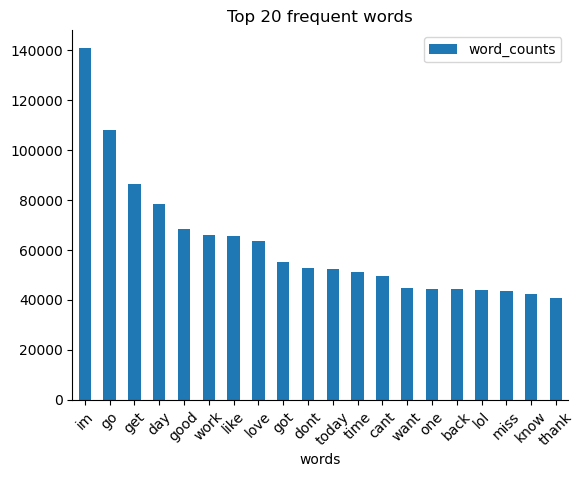

In [ ]:
plot_words(words, word_counts)
plt.show()

We can see from the figure above that most common words are about going somewhere or about work or about daily plans. The tokens such as miss, love want shows affinity towards certain objects or person. Finally, gratitude words such as good, thank, like are also present in the most common words. 

## Modelling <a name="modelling"></a>   

### Logistic Regression <a name="log"></a>   

Let's train a logistic regression model to predict sentiment for a tweet. 


In [17]:
log_model = LogisticRegression(C=0.1, max_iter=1000)

log_model.fit(X_train_transformed, y_train)

LogisticRegression(C=0.1, max_iter=1000)

I am saving this model as a pkl file for later use. We will see later during the hyperparameter optimization that this model has the optimum value of heyper parameter. Also we will use this model when we test it on the scraped data from twitter.  

In [31]:
joblib.dump(log_model, 'LogisticRegressoinModel.pkl')

['LogisticRegressoinModel.pkl']

In [18]:
log_model.score(X_validation_transformed, y_validation)

0.7735311100309583

- This accuracy is not bad at all. Our base model would have an accuracy of 0.5 if we assume it was a random classifier.   
- Let's optimize our model to get better accuracy. For this, we can change the parameter C and the values of maximum iterations.  

In [19]:
#let's optimize our model to get better accuracy. 
def optimize_log(C_values):
    """Optimize the logistic regression model to get optimum accuracy
    Parameters
    ----------
    C_values: array, values of C
    Returns
    Training and test set accuracy"""
    score_dict = {'C_values':C_values, 'train_score':[], 'validation_score':[]}
    
    
    for c in C_values:
        #initialize the model
        log_model = LogisticRegression(C=c, max_iter=1000)
        #fit the model on training set 
        log_model.fit(X_train_transformed, y_train)
        
        #get the score on training and validation set
        score_dict['train_score'].append(log_model.score(X_train_transformed, y_train))
        score_dict['validation_score'].append(log_model.score(X_validation_transformed, y_validation))
        
    return pd.DataFrame(score_dict)

In [ ]:
C_values = np.power(10.0, np.arange(-3, 4))
score_df = optimize_log(C_values)

C:\Users\SHARM~1.LAP\AppData\Local\Temp/ipykernel_14232/2587502794.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_df = score_df.append({'train_score':log_model.score(X_train_transformed, y_train),
C:\Users\SHARM~1.LAP\AppData\Local\Temp/ipykernel_14232/2587502794.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_df = score_df.append({'train_score':log_model.score(X_train_transformed, y_train),
C:\Users\SHARM~1.LAP\AppData\Local\Temp/ipykernel_14232/2587502794.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  score_df = score_df.append({'train_score':log_model.score(X_train_transformed, y_train),
C:\Users\SHARM~1.LAP\AppData\Local\Temp/ipykernel_14232/2587502794.py:19: FutureWarning: The frame.append 

,train_score,validation_score
0,0.748396,0.747874
1,0.768407,0.768096
2,0.778348,0.774767
3,0.780704,0.77452
4,0.780707,0.77388
5,0.780708,0.773795
6,0.780705,0.773792


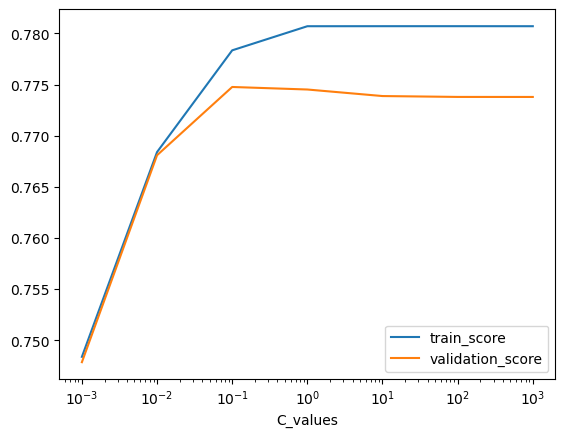

In [ ]:
score_df.plot(x= 'C_values', y=['train_score', 'validation_score'])
plt.xscale('log')

We can see from the figure above that both the training and test set accuracy increase with in crease in the value of C due to increase in the model complexity. The test set accuracy becomes constant after a value of c equal to 0.1. After this value variance in the model increases due to increase in model complexity. At this point, our model has learned to fit on the noise points in the data. The optimum value of C is therefore either 1 or 0.1. I am selecting 0.1 for this study, because more regularization means more generalization of model. 

Let's calculate accuracy of model with optimum parameters.   

In [20]:
#first re train the model with optimum parameters 
log_model = LogisticRegression(C=0.1, max_iter=1000)

log_model.fit(X_train_transformed, y_train)

log_model.score(X_validation_transformed, y_validation)

0.7735311100309583

Now let's interpret the results from our logistic regression model. One way to interpret the results to understand the effect of features on the the sentiment of tweet. This can be done by getting coefficients from logistic regression models. Let's first define a function to get the coefficients from logistic regression model. 

In [21]:
#let's plot the coefficients now 
def plot_coeff(log_model, words, top=20):
    """Plots the coefficients from a logistic regression model
    Parameters
    ----------
    log_model: sklearn_model
    words: array, feature names
    Returns:
    A matplotlib chart"""
    
    coeff_df = pd.DataFrame({'words':words,
                            'coeff':log_model.coef_[0]})
    
    #let's plot top 20 coefficients for positive and negative sentiment
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,6))
    
    coeff_df.set_index('words').sort_values(by='coeff', ascending=False).head(top).plot(kind='barh',
                                                                                       ax=ax1,
                                                                                       color='orange')
    ax1.set_title('Positive predictors')
    ax1.invert_yaxis()
    
    coeff_df.set_index('words').sort_values(by='coeff', ascending=False).tail(top).plot(kind='barh',
                                                                                       ax=ax2,
                                                                                       color='green')
    ax2.set_title('Negative predictors')
    ax2.invert_xaxis()
    sns.despine()
    plt.tight_layout()
    
    return ax1, ax2

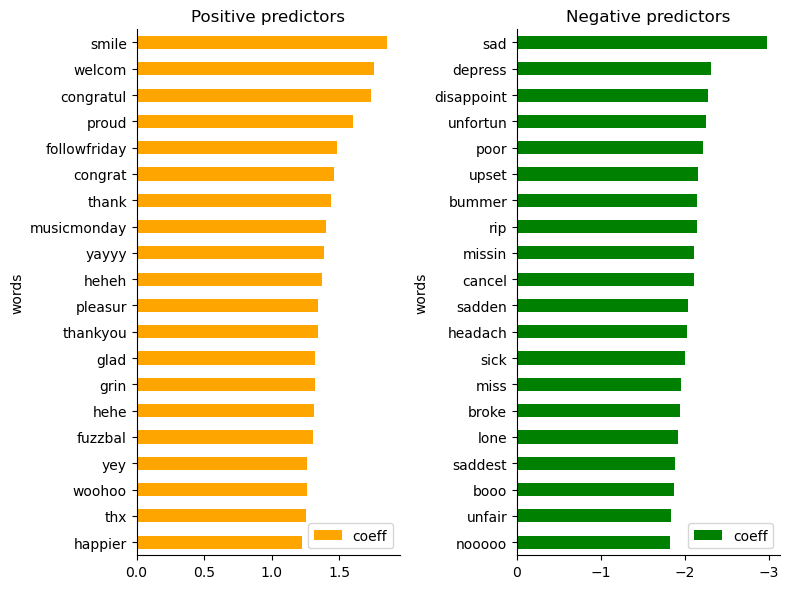

In [22]:
plot_coeff(log_model, words, top=20)
plt.show()

In order to understand top words which are most predictive of positive and negative sentiment for a tweet, coefficients from the logistic regression model are plotted in the figure above.  
- The coefficients of logistic regression model can be interpreted in terms of odds ratio, that is, the probability of an event happening as a proportion of the probability of that event not happening. The odds ration is calculated by taking exponential of the coefficients from logistic regression model. So for our case, with a unit increase in the coefficient for the words from tweet with positive sentiment the odds ratio of tweet having positive sentiment increases by an amount of $e^{coefficient}$.
- The higher the odds ratio ($e^{coefficient}$), the greater the chances of review being positive.     

For our case the coefficients are pretty self explanatory and intuitive. We know that words such as `smile`, `welcome`, `proud` carry positive sentiment with them and therefore are strong predictor of positive sentiment. Similarly, the words such as `sad`, `depress`, `disappoint` carry negative sentiment with them and therefore they are strong predictor of negative sentiment.     

Now let's plot the confusion matrix for our logistic regression model. 

In [23]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Get class predictions
y_pred = log_model.predict(X_validation_transformed)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_validation, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted negative sentiment", "Predicted positive"],
    index=["True negative sentiment", "True positive sentiment"]
)

display(cf_df)

,Predicted negative sentiment,Predicted positive
True negative sentiment,115342,38812
True positive sentiment,30610,121777


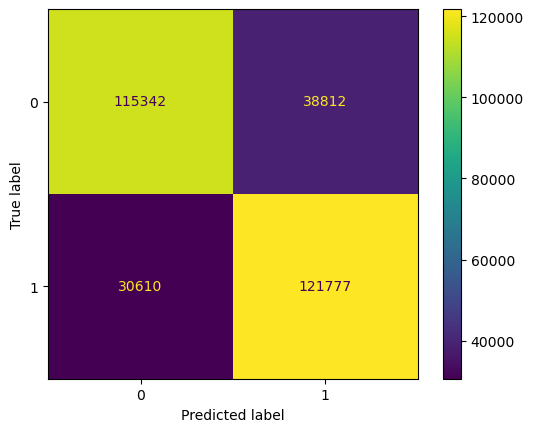

In [24]:
#plot the confusion matrix
plot_confusion_matrix(log_model, X_validation_transformed, y_validation);

From the figure above we can see the confusion matrix for our best logistic regression model. The confusion matrix show that true positives and true negatives outnumber false negatives and false positives. To understand the percentages of true positives with respect to actual positives and predicted positives, let's get precision, recall, and f1 score for our model.

In [25]:
from sklearn.metrics import classification_report

print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.75      0.77    154154
           1       0.76      0.80      0.78    152387

    accuracy                           0.77    306541
   macro avg       0.77      0.77      0.77    306541
weighted avg       0.77      0.77      0.77    306541



From the classification report, we can see the recall score and precision scores for each of the class. Precision for class 1 is the ration between the number of true positive sentiment and total number of tweets with positive sentiment. Recall is the ratio between the number of true positive sentiment tweets and all predicted positive sentiment tweets by our logistic regression model.


F1 score is just the hormonic mean of precision and recall. Higher or lower f1 score shows that both precision and recall are maximum or minimum at the same time. f1 score is used to strike a balance between precision and recall score.

For our logistic regression model, there is no significant difference between precision, recall, and f1 score. This implies that our target variable does not have class imbalance.  


The other way to strike balance between precision and recall is to plot true and false positive rate. This plot is also known as ROC curve.

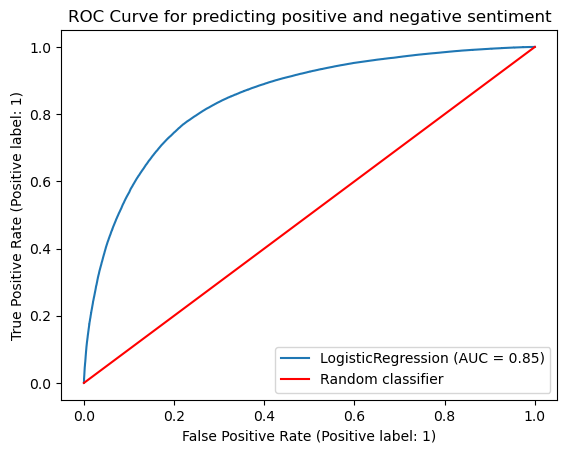

In [26]:
from sklearn.metrics import plot_roc_curve

plot_roc_curve(log_model, X_validation_transformed, y_validation)
plt.title('ROC Curve for predicting positive and negative sentiment')
plt.plot([0,1], [0,1], '-r', label='Random classifier')
plt.legend()
plt.show()

The above graph shows relationship between true and false positive rate for our logistic regression model. Our goal is to have minimum false positive rate while having maximum true positive rate at the same time. This can be achieved by maximizing the area under curve of above graph for our model. The area under the curve is known as AUC score.

The red line in the graph corresponds to a random classifier, that is, the false positive rate and false negative rate are same for different threshold values. Our classifier is above this line, which represents gain in information by training a logistic regression model. 


The AUC score for logistic regression model is 0.85.

Now that we have a good understanding of features and their predictive power on sentiment of tweets, let's automate the process to further hyper-tune the parameters and see if the model accuracy is improved. One way to do is develope sklearn pipeline. 

Let's develope an sklearn pipeline for hyper-parameter optimization. 

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp #for efficiency in pipeline - this will store  result temporarily in temp folder 


In [28]:
cachedir = mkdtemp(dir='../temp') #make sure you create a temp folder

estimators = [('count_vectorizer', CountVectorizer()), #vectorize data 
              ('model', LogisticRegression(max_iter=1000, solver='saga'))] #fit a logistic model

pipe = Pipeline(estimators, memory = cachedir) #make a pipeline
pipe #checkout the pipe

Pipeline(memory='../temp\\tmpw2yti3il',
         steps=[('count_vectorizer', CountVectorizer()),
                ('model', LogisticRegression(max_iter=1000, solver='saga'))])

In [29]:
#let's perform grid search for the hyperparameter optimization
param_grid = {
        'count_vectorizer__min_df': [10, 20, 30, 50], 
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    }

#initialize gird for the pipe
grid = GridSearchCV(pipe, param_grid, cv=5)  

#checkout the grid 
grid

GridSearchCV(cv=5,
             estimator=Pipeline(memory='../temp\\tmpw2yti3il',
                                steps=[('count_vectorizer', CountVectorizer()),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           solver='saga'))]),
             param_grid={'count_vectorizer__min_df': [10, 20, 30, 50],
                         'model__C': [0.001, 0.01, 0.1, 1, 10, 100]})

<span style="color:red">Warning, the cell below takes 15.5 hours to run </span>. 

In [30]:
#fit on the training set 
fitted_gird = grid.fit(X, y)

E:\Machine Learning Engineer\BrainStation\Bootcamp\7.Capstone\capstone_env\lib\site-packages\sklearn\pipeline.py:303: UserWarning: Persisting input arguments took 5.65s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  X, fitted_transformer = fit_transform_one_cached(
E:\Machine Learning Engineer\BrainStation\Bootcamp\7.Capstone\capstone_env\lib\site-packages\sklearn\pipeline.py:303: UserWarning: Persisting input arguments took 5.54s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kind

In [31]:
fitted_gird.best_estimator_

Pipeline(memory='../temp\\tmpw2yti3il',
         steps=[('count_vectorizer', CountVectorizer(min_df=10)),
                ('model',
                 LogisticRegression(C=0.1, max_iter=1000, solver='saga'))])

The best estimator (logistic regression model) was the one with `min_df` parameter 10 and a c value of 0.1. The accuracy of best logistic regression model was found to be 0.77 which is approximately same as of the logistic regression model with `min_df` as 20 (0.774). To save the computation cost, I am using C=0.1 and `min_df` = 20 for my final logistic regression model.   

In [35]:
fitted_gird.best_score_

0.7695393238285487

In [ ]:
joblib.dump(fitted_gird, 'log_grid.pkl')

### KNN model  <a name="knn"></a>   

Let's fit some more models to see if we can improve the performance of our model. 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

In [ ]:
#fit a knn model to this data
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_transformed, y_train)
knn_model.score(X_validation_transformed, y_validation)

0.6991071341190901

The accuracy of knn model on validation set is 0.7 which is lower than the accuracy of logistic regression model. Also the calculation time fitting model on this data set is in hours. Looking at the time it takes to just fit one model, I am not hyper tuning parameters for the knn classifier. 

### Decision Tree Classifier <a name="DT"></a>   

In [ ]:
#let's see how decision trees performs here
DT_model = DecisionTreeClassifier(max_depth=10)
DT_model.fit(X_train_transformed, y_train)
DT_model.score(X_validation_transformed, y_validation)

0.5883062950796142

Fitting the grid for logistic regression took a day, while fitting knn classifier without any hyper parameter tuning took hours. The long training time is due to fact that we have 1.5 million rows in our data. For training more models, let's just take a sample of data. In the next book, I will take a sample of data and perform modelling with some advanced models. 

### XGBoost <a name="XGB"></a>  

XGBoost stands for eXtreme Gradient Boosting. This is one of the type of implementation of gradient boosting that tends to be more accurate and faster than the sklearn's implementation. XGBoost work well when there is categorical data in features and also when the number features are less than the training samples. 

For our case the number of samples largely outnumber the number of features. Let's try XGBoost and see how it performs.   

In [36]:
from xgboost import XGBClassifier

E:\Machine Learning Engineer\BrainStation\Bootcamp\7.Capstone\capstone_env\lib\site-packages\xgboost\compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [37]:
#initialize the classifier 
XGB_model = XGBClassifier(n_estimators=41, max_depth=3)

In [38]:
#fit the model 
XGB_model.fit(X_train_transformed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=41, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
XGB_model.score(X_validation_transformed, y_validation)

0.6969377668892579

The accuracy of XGB on validation set is around 0.7 which is not great as compared to the logistic regression model. One thing to note is that XGB is sensitive to hyper-parameter tuning. So let's optimize the hyper-parameter and see how does it perform.    

In [41]:
def opt_XGB(n_estimators, max_depths):
    """Get's the accuracy of xgb for different hyperparameters"""


    score_dict = {'pair':[], 'train_score':[], 'validation_score':[]}

    for n_estimator in n_estimators:

        for depth in max_depths:

            #initialize the model 
            XGB_model = XGBClassifier(n_estimators=n_estimator, max_depth=depth)

            #fit the model
            XGB_model.fit(X_train_transformed, y_train)

            #get the accuracy on training and test set 
            score_dict['train_score'].append(XGB_model.score(X_train_transformed, y_train))
            score_dict['validation_score'].append(XGB_model.score(X_validation_transformed, y_validation))
            score_dict['pair'].append((n_estimator, depth))

    return pd.DataFrame(score_dict)

<span style="color:red">Warning, the cell below takes more than 1000 minutes to run </span>. It takes that long for parameters `np.arange(1, 1000, 10), np.arange(1, 100, 2)`

In [47]:
#this should run in 15 minutes 
score_df = opt_XGB(np.arange(1, 100, 10), np.arange(1, 10, 2))

Text(0.5, 0, 'pair (n_estimator, depth)')

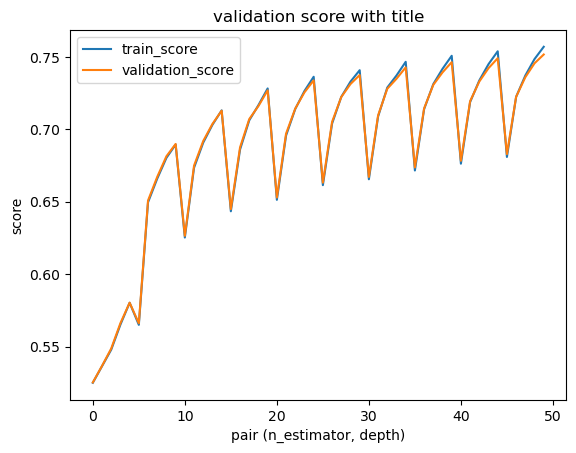

In [53]:
score_df.plot(y=['train_score', 'validation_score'])
plt.title('validation score with title')
plt.ylabel('score')
plt.xlabel('pair (n_estimator, depth)')


The accuracy is increasing with key value pair (n_estimator, depth). This code is taking too long. Further hyper tuning of hyeper parameter is required. 

In [49]:
#best parameters 
score_df.iloc[score_df['validation_score'].idxmax(), 0]

(91, 9)

The optimum value of hyper parameter from the hyper parameter turning until now is (91, 9). That is n_estimators =91 and depth=9

In [ ]:
#the best model until now 
XGB_model = XGBClassifier(n_estimators=91, max_depth=9)
XGB_model.fit(X_train_transformed, y_train)
joblib.dump(XGB_model, 'best_XGB')

### Random forest classifier <a name="XGB"></a>    
Let's see how random forest performs on this data. This took a lot of time so I am keeping the code only here. 

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(X_train_transformed, y_train);


#check the accuracy 
rf.score(X_validation_transformed, y_validation);

## Conclusion <a name="conclusion"></a>  

In this notebook we first transformed text data to numerical data after tokenizing, removing stop words, and stemming. We used countvectorizer to make document-term matrix using the tokens.   

After changing text data to numbers, data was split into training and validation set. Different machine learning models were trained on the training data. Logistic regression, knn, decision trees, random forest, and XGBoost models were trained on the training data. 

Validation set was used for heyper-parameter tuning for some of the models due to extensive amount of time required to tune the hyper parameters. 

In order to train models within a practical time, we will sample a part of the data and train our models on them. In next notebook some more models are trained on a sample of data. Also TF-IDF vectorizer was used to form document term matrix.      